In [1]:
pip install opencv-python scikit-learn matplotlib pillow tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm

DATASET_PATH = "/kaggle/input/image-retrivel/UCMerced_LandUse/Images"
IMAGE_SIZE = (128, 128)

images = []
labels = []
class_names = sorted(os.listdir(DATASET_PATH))

for class_name in class_names:
    class_folder = os.path.join(DATASET_PATH, class_name)
    for image_file in os.listdir(class_folder):
        img_path = os.path.join(class_folder, image_file)
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMAGE_SIZE)
        images.append(img)
        labels.append(class_name)

images = np.array(images)
labels = np.array(labels)

print(f"Loaded {len(images)} images with shape: {images[0].shape}")

Loaded 2100 images with shape: (128, 128, 3)


In [3]:
from skimage.feature import local_binary_pattern

def extract_features(image):
    # Color histogram
    chans = cv2.split(image)
    color_hist = np.concatenate([
        cv2.calcHist([ch], [0], None, [32], [0, 256]).flatten()
        for ch in chans
    ])

    # Texture (LBP)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), density=True)

    return np.concatenate([color_hist, lbp_hist])

features = np.array([extract_features(img) for img in tqdm(images)])
print("✅ Features shape:", features.shape)


100%|██████████| 2100/2100 [00:07<00:00, 286.81it/s]

✅ Features shape: (2100, 105)


In [4]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

le = LabelEncoder()
labels_encoded = le.fit_transform(labels)


In [5]:
import random

def evaluate_firefly(solution, features, labels):
    mask = solution > 0.5
    if np.sum(mask) == 0:
        return 0
    X_sel = features[:, mask]
    X_train, X_test, y_train, y_test = train_test_split(X_sel, labels, test_size=0.3, stratify=labels)
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))
    return acc


In [6]:
def firefly_algorithm(features, labels, n_fireflies=20, max_iter=20, alpha=0.5, beta0=1, gamma=1):
    n_features = features.shape[1]
    fireflies = np.random.rand(n_fireflies, n_features)
    fitness = np.array([evaluate_firefly(f, features, labels) for f in fireflies])

    for t in range(max_iter):
        for i in range(n_fireflies):
            for j in range(n_fireflies):
                if fitness[j] > fitness[i]:
                    r = np.linalg.norm(fireflies[i] - fireflies[j])
                    beta = beta0 * np.exp(-gamma * r**2)
                    fireflies[i] += beta * (fireflies[j] - fireflies[i]) + alpha * (np.random.rand(n_features) - 0.5)
                    fireflies[i] = np.clip(fireflies[i], 0, 1)
            fitness[i] = evaluate_firefly(fireflies[i], features, labels)
        print(f"🔥 Iteration {t+1} | Best Accuracy: {np.max(fitness):.4f}")
    
    best_idx = np.argmax(fitness)
    return fireflies[best_idx], fitness[best_idx]


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

best_solution, best_score = firefly_algorithm(features_scaled, labels_encoded)
selected_features = features_scaled[:, best_solution > 0.5]

print(f"✅ Final Accuracy (Best Firefly): {best_score:.4f}")
print(f"Selected {np.sum(best_solution > 0.5)} features out of {features.shape[1]}")


🔥 Iteration 1 | Best Accuracy: 0.6556
🔥 Iteration 2 | Best Accuracy: 0.6714
🔥 Iteration 3 | Best Accuracy: 0.6683
🔥 Iteration 4 | Best Accuracy: 0.6651
🔥 Iteration 5 | Best Accuracy: 0.6524
🔥 Iteration 6 | Best Accuracy: 0.6667
🔥 Iteration 7 | Best Accuracy: 0.6651
🔥 Iteration 8 | Best Accuracy: 0.6667
🔥 Iteration 9 | Best Accuracy: 0.6397
🔥 Iteration 10 | Best Accuracy: 0.6619
🔥 Iteration 11 | Best Accuracy: 0.6397
🔥 Iteration 12 | Best Accuracy: 0.6651
🔥 Iteration 13 | Best Accuracy: 0.6619
🔥 Iteration 14 | Best Accuracy: 0.6683
🔥 Iteration 15 | Best Accuracy: 0.6460
🔥 Iteration 16 | Best Accuracy: 0.6492
🔥 Iteration 17 | Best Accuracy: 0.6540
🔥 Iteration 18 | Best Accuracy: 0.6587
🔥 Iteration 19 | Best Accuracy: 0.6524
🔥 Iteration 20 | Best Accuracy: 0.6524
✅ Final Accuracy (Best Firefly): 0.6524
Selected 62 features out of 105


In [8]:
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(selected_features, labels_encoded, test_size=0.3)
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))


                   precision    recall  f1-score   support

     agricultural       0.91      0.75      0.82        28
         airplane       0.47      0.49      0.48        35
  baseballdiamond       0.75      0.43      0.55        28
            beach       0.83      0.67      0.74        30
        buildings       0.33      0.38      0.36        26
        chaparral       0.76      0.88      0.82        33
 denseresidential       0.43      0.56      0.48        27
           forest       0.67      0.81      0.73        36
          freeway       0.67      0.60      0.63        30
       golfcourse       0.56      0.79      0.66        28
           harbor       0.91      0.91      0.91        33
     intersection       0.38      0.43      0.40        35
mediumresidential       0.44      0.91      0.60        34
   mobilehomepark       0.66      0.78      0.71        27
         overpass       0.73      0.53      0.61        36
       parkinglot       0.34      0.38      0.36       

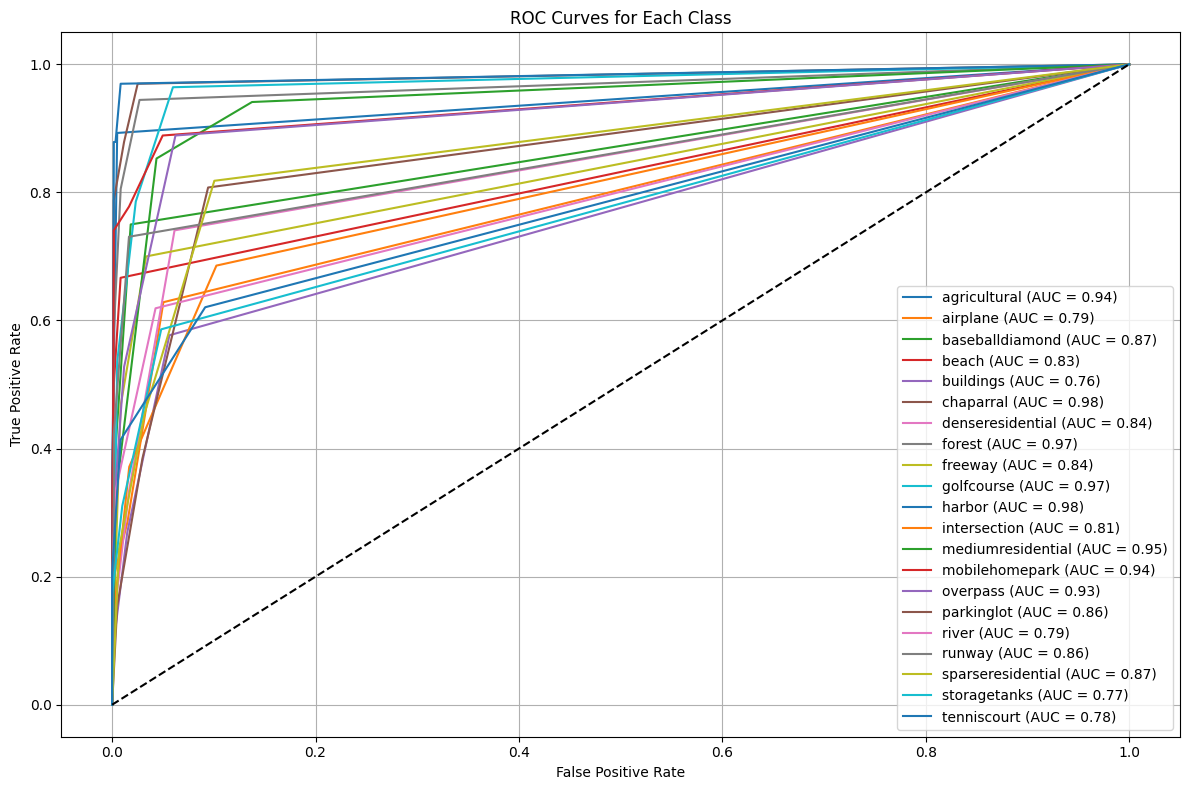

In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the output labels for multi-class AUC
y_test_bin = label_binarize(y_test, classes=np.unique(labels_encoded))
y_pred_prob = clf.predict_proba(X_test)

# Number of classes
n_classes = y_test_bin.shape[1]

# Plot setup
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{le.classes_[i]} (AUC = {roc_auc:.2f})')

# Plot ROC curve for each class
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class")
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()


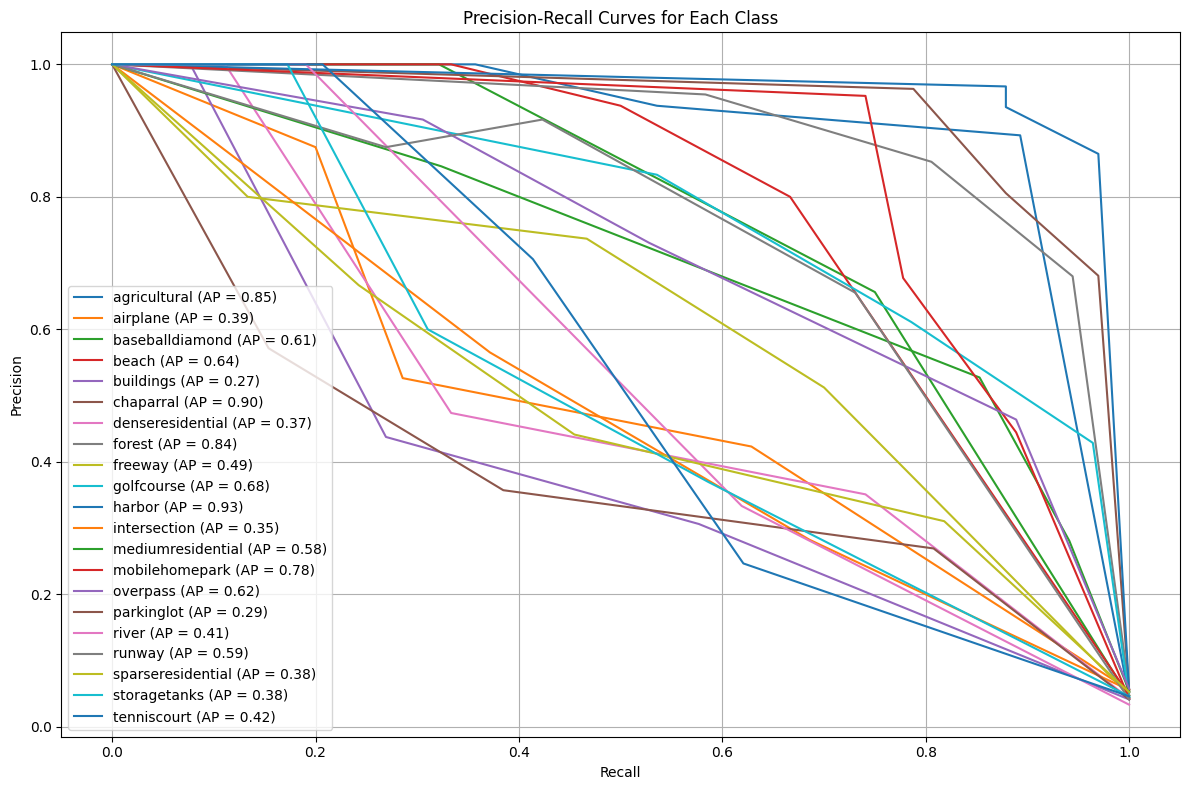

In [10]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Plot setup
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'{le.classes_[i]} (AP = {avg_precision:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for Each Class")
plt.legend(loc='lower left')
plt.grid()
plt.tight_layout()
plt.show()


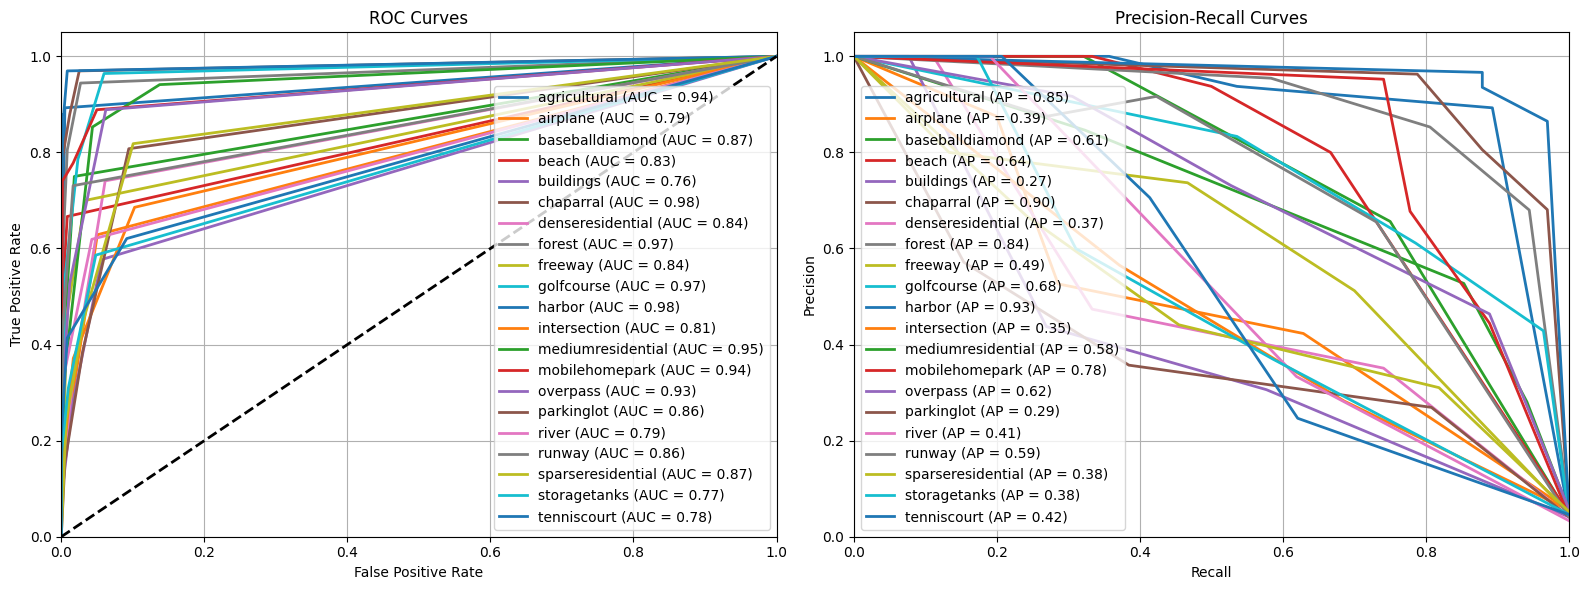

In [14]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve Plot
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, lw=2, label=f'{le.classes_[i]} (AUC = {roc_auc:.2f})')

axes[0].plot([0, 1], [0, 1], 'k--', lw=2)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves')
axes[0].legend(loc="lower right")
axes[0].grid()

# Precision-Recall Curve Plot
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_pred_prob[:, i])
    axes[1].plot(recall, precision, lw=2, label=f'{le.classes_[i]} (AP = {ap:.2f})')

axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curves')
axes[1].legend(loc="lower left")
axes[1].grid()

plt.tight_layout()
plt.show()


<Figure size 800x600 with 0 Axes>

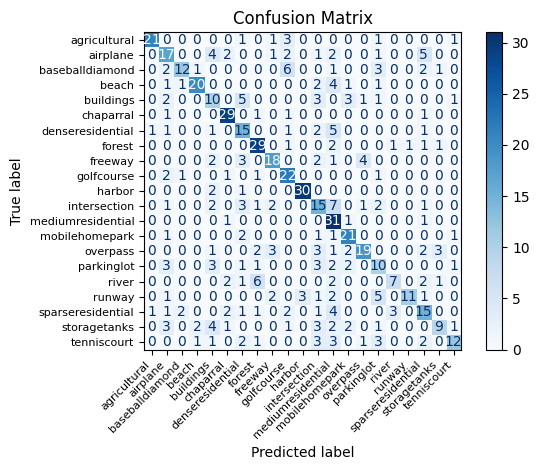

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.xticks(rotation=45, ha='right')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [17]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)

# Display full report
import pandas as pd

report_df = pd.DataFrame(report).transpose()
print(report_df)

# Find class with highest accuracy (f1-score used as proxy)
sorted_f1 = report_df.iloc[:-3].sort_values(by="f1-score", ascending=False)  # Ignore 'accuracy', 'macro avg', 'weighted avg'

top_class = sorted_f1.head(1)
print("\n Class with highest F1-score:")
print(top_class)


                   precision    recall  f1-score     support
agricultural        0.913043  0.750000  0.823529   28.000000
airplane            0.472222  0.485714  0.478873   35.000000
baseballdiamond     0.750000  0.428571  0.545455   28.000000
beach               0.833333  0.666667  0.740741   30.000000
buildings           0.333333  0.384615  0.357143   26.000000
chaparral           0.763158  0.878788  0.816901   33.000000
denseresidential    0.428571  0.555556  0.483871   27.000000
forest              0.674419  0.805556  0.734177   36.000000
freeway             0.666667  0.600000  0.631579   30.000000
golfcourse          0.564103  0.785714  0.656716   28.000000
harbor              0.909091  0.909091  0.909091   33.000000
intersection        0.375000  0.428571  0.400000   35.000000
mediumresidential   0.442857  0.911765  0.596154   34.000000
mobilehomepark      0.656250  0.777778  0.711864   27.000000
overpass            0.730769  0.527778  0.612903   36.000000
parkinglot          0.34

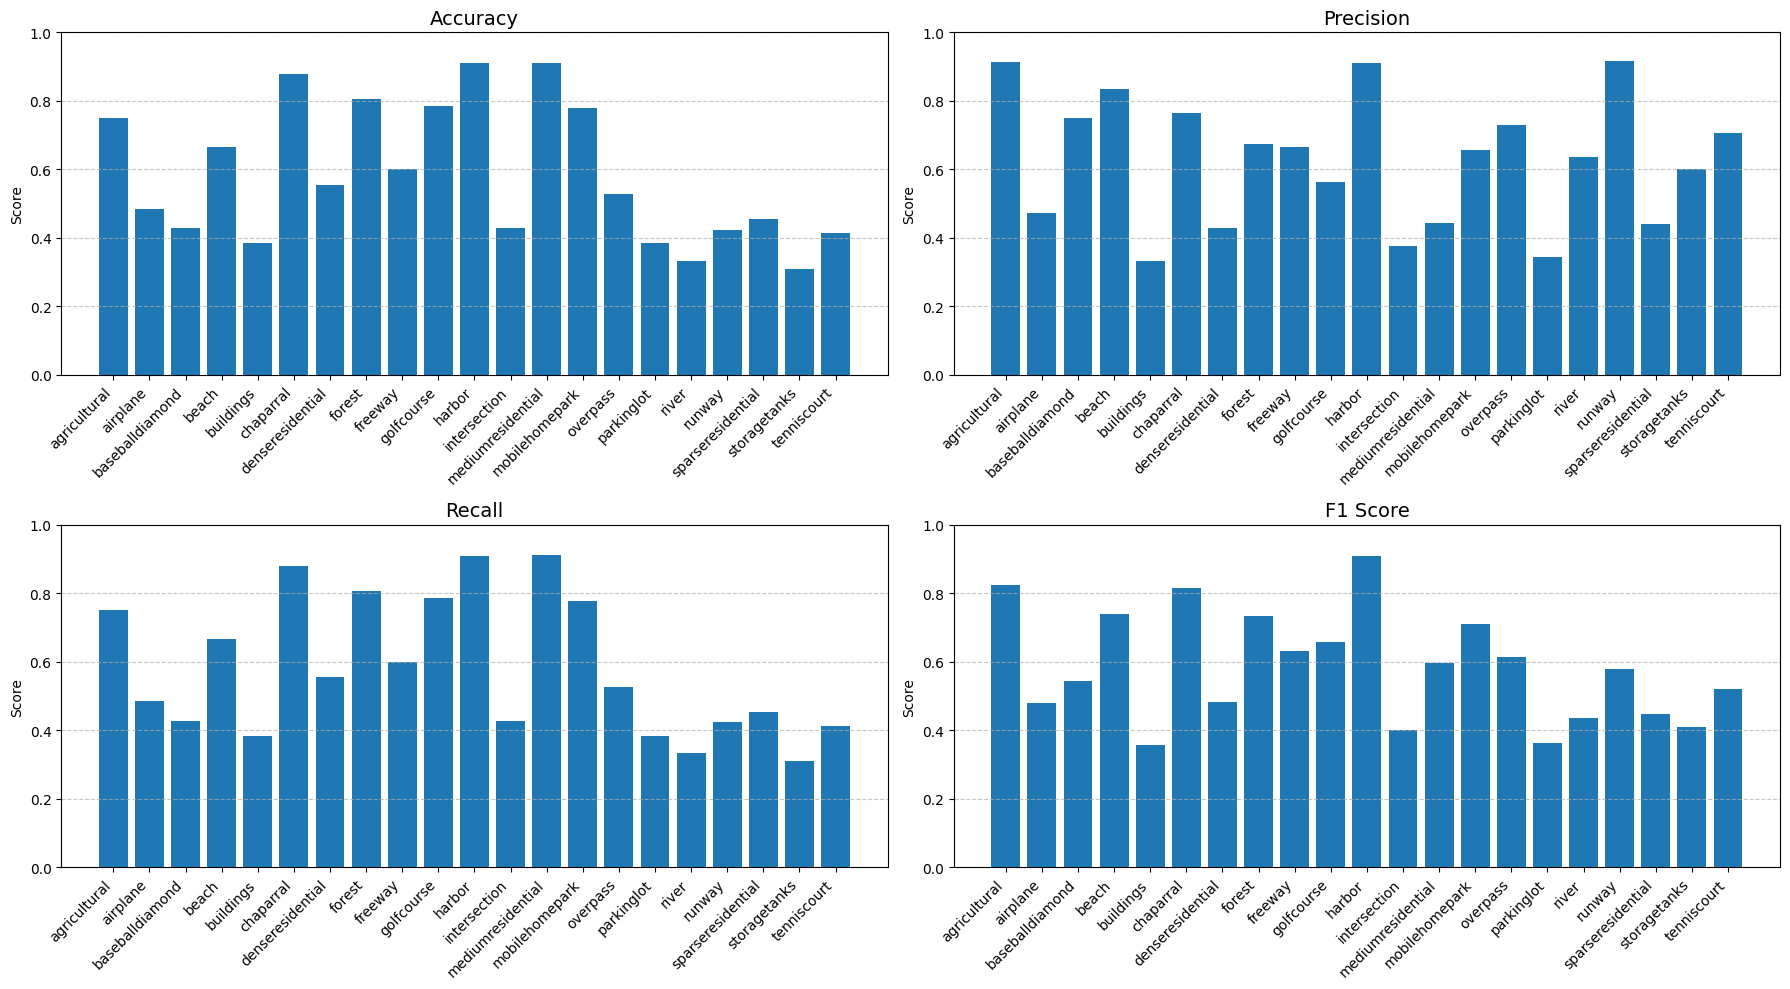

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Ensure y_test and y_pred are numpy arrays
y_test = np.array(y_test)
y_pred = np.array(y_pred)

# Number of classes
num_classes = len(class_names)

# Calculate per-class metrics
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Accuracy per class = correct predictions / total samples of that class
accuracy = []
for i in range(num_classes):
    idx = y_test == i
    acc = np.sum(y_pred[idx] == i) / np.sum(idx)
    accuracy.append(acc)
accuracy = np.array(accuracy)

# Plotting
metrics = [accuracy, precision, recall, f1]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

fig, axes = plt.subplots(2, 2, figsize=(18, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.bar(class_names, metrics[i])
    ax.set_title(metric_names[i], fontsize=14)
    ax.set_ylabel("Score")
    ax.set_xticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
